In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)


<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import matplotlib
# matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

# import multiprocessing as mp
# mp.set_start_method('spawn', force=True)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


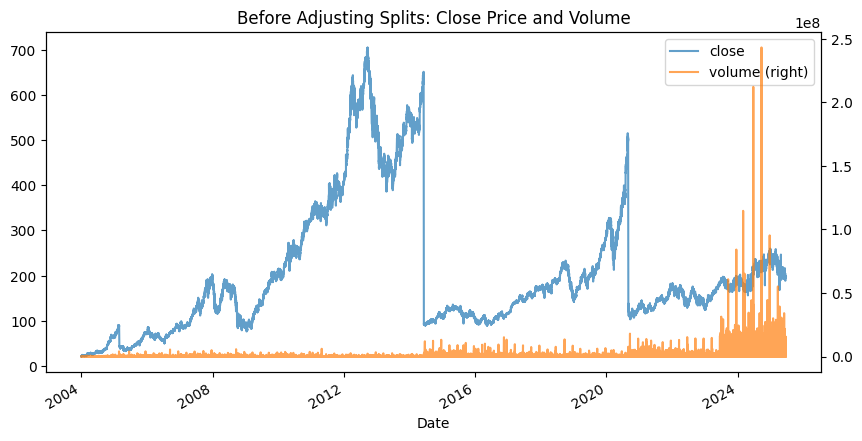

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


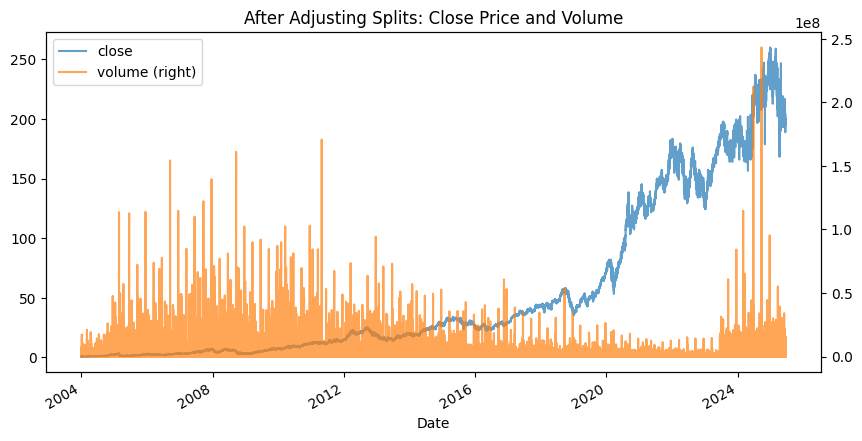

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 11:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_spread     = params.bidasktoclose_spread
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    percentile_ref,
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # A) dynamic reference profit
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        percentile_ref          = percentile_ref,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    del simulation
    gc.collect()

    # — use all trading days for the daily-P&L average —
    num_days      = trades.count_trading_days(df, params.regular_start, params.regular_end)
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days if num_days else 0.0

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
# calculate all possible look_backs, and create a list to use in the objective function,
# considering that it must be less than half time difference between regular_start and the first available timestamp

# 1) grab first timestamp’s time
first_ts = df.index.min()          # e.g. Timestamp('2004-01-02 11:30:00')
first_time = first_ts.time()       # → datetime.time(11, 30)

# 2) convert to minutes since midnight
first_minutes   = first_time.hour * 60 + first_time.minute
start_minutes   = params.regular_start.hour * 60 + params.regular_start.minute

# 3) compute half the interval
diff_minutes  = start_minutes - first_minutes         # e.g. 14:30 − 11:30 = 330
half_minutes  = diff_minutes / 2                      # → 165.0

# 4) how many full 30-min chunks fit below half_minutes?
n_steps = int(half_minutes // 30)                     # floor(165/30) = 5

# 5) build your list of multiples
look_backs = [30 * i for i in range(1, n_steps + 1)]   # → [30, 60, 90, 120, 150]

print(look_backs)


def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", look_backs),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.05, 0.95),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.05, 0.95),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.05, 0.95),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.05, 0.95),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.05, 0.95),
        "percentile_ref"          : trial.suggest_categorical("percentile_ref", [50,75,90]),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [1,2,3,5,10,15,20,30]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.05, 0.95),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 0.95),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.01, 0.69),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.001, 0.069),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[30, 60, 90]


[I 2025-08-08 17:01:50,296] A new study created in RDB with name: no-name-94a00ed5-d937-4197-beb5-c6ce6ae0e1b7


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:04:48,882] Trial 0 finished with value: 0.19857907407407407 and parameters: {'look_back': 60, 'min_prof_thr': 0.8239236950435825, 'max_down_prop': 0.7365176722345939, 'gain_tightening_factor': 0.42962156695900844, 'merging_retracement_thr': 0.8229530082756901, 'merging_time_gap_thr': 0.056822197802081344, 'percentile_ref': 75, 'smooth_win_sig': 5, 'pre_entry_decay': 0.7044723262953154, 'short_penalty': 0.26106885702780425, 'trailing_stop_thresh': 0.3523248891280522, 'buy_threshold': 0.007980331426392895}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $1072.33
→ Avg daily return (all days)          : $0.1986
→ Total trades                          : 2241
→ Avg return per trade                  : $0.4785



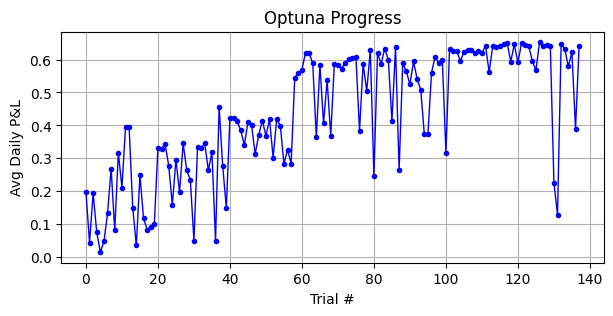

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:07:56,072] Trial 1 finished with value: 0.043573518518518525 and parameters: {'look_back': 60, 'min_prof_thr': 0.7672274919536318, 'max_down_prop': 0.5738980760786593, 'gain_tightening_factor': 0.7237276292062118, 'merging_retracement_thr': 0.38343990923885213, 'merging_time_gap_thr': 0.7264741506054814, 'percentile_ref': 75, 'smooth_win_sig': 5, 'pre_entry_decay': 0.5850601200493863, 'short_penalty': 0.8152082206636976, 'trailing_stop_thresh': 0.5745270027699936, 'buy_threshold': 0.046433153888170965}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $235.30
→ Avg daily return (all days)          : $0.0436
→ Total trades                          : 314
→ Avg return per trade                  : $0.7494

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:11:25,162] Trial 2 finished with value: 0.19406740740740744 and parameters: {'look_back': 90, 'min_prof_thr': 0.3305334127496823, 'max_down_prop': 0.49023989574498594, 'gain_tightening_factor': 0.7556030894838898, 'merging_retracement_thr': 0.35364718873607576, 'merging_time_gap_thr': 0.07553083610341929, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.10005679873894788, 'short_penalty': 0.7152908092540644, 'trailing_stop_thresh': 0.07119941518544934, 'buy_threshold': 0.059790390990715564}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $1047.96
→ Avg daily return (all days)          : $0.1941
→ Total trades                          : 3985
→ Avg return per trade                  : $0.2630

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:14:38,853] Trial 3 finished with value: 0.07601888888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.7947830463008949, 'max_down_prop': 0.14693602653798854, 'gain_tightening_factor': 0.2586701848015953, 'merging_retracement_thr': 0.7653108636355523, 'merging_time_gap_thr': 0.8069328586955585, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.5390730225514071, 'short_penalty': 0.840598115389777, 'trailing_stop_thresh': 0.5719988400246983, 'buy_threshold': 0.019288073712952356}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $410.50
→ Avg daily return (all days)          : $0.0760
→ Total trades                          : 603
→ Avg return per trade                  : $0.6808

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:18:11,141] Trial 4 finished with value: 0.014865740740740742 and parameters: {'look_back': 90, 'min_prof_thr': 0.7713750290941103, 'max_down_prop': 0.3237281281313204, 'gain_tightening_factor': 0.8719929324883674, 'merging_retracement_thr': 0.9067958984588319, 'merging_time_gap_thr': 0.9286849183294136, 'percentile_ref': 90, 'smooth_win_sig': 15, 'pre_entry_decay': 0.8896614521425162, 'short_penalty': 0.3372920038892795, 'trailing_stop_thresh': 0.08347854782803167, 'buy_threshold': 0.04768181001720352}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $80.28
→ Avg daily return (all days)          : $0.0149
→ Total trades                          : 71
→ Avg return per trade                  : $1.1306

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:21:41,732] Trial 5 finished with value: 0.04785814814814814 and parameters: {'look_back': 90, 'min_prof_thr': 0.3868436348225347, 'max_down_prop': 0.26889685588008744, 'gain_tightening_factor': 0.4048558143220413, 'merging_retracement_thr': 0.884312677872312, 'merging_time_gap_thr': 0.49180125693264437, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8931485000214219, 'short_penalty': 0.6176320118615978, 'trailing_stop_thresh': 0.32829635762606024, 'buy_threshold': 0.04496651381358787}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $258.43
→ Avg daily return (all days)          : $0.0479
→ Total trades                          : 383
→ Avg return per trade                  : $0.6748

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:25:18,258] Trial 6 finished with value: 0.1326572222222222 and parameters: {'look_back': 90, 'min_prof_thr': 0.15766539277846744, 'max_down_prop': 0.1492733328921874, 'gain_tightening_factor': 0.9057678255474176, 'merging_retracement_thr': 0.10485966059774358, 'merging_time_gap_thr': 0.7557827664192787, 'percentile_ref': 90, 'smooth_win_sig': 5, 'pre_entry_decay': 0.4675384085290828, 'short_penalty': 0.9101777877988761, 'trailing_stop_thresh': 0.688348251070044, 'buy_threshold': 0.04937406169105559}. Best is trial 0 with value: 0.19857907407407407.


→ Total return across 5400 trading days: $716.35
→ Avg daily return (all days)          : $0.1327
→ Total trades                          : 1167
→ Avg return per trade                  : $0.6138

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:28:59,178] Trial 7 finished with value: 0.2687714814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.8002025159813523, 'max_down_prop': 0.2725683283117744, 'gain_tightening_factor': 0.42312918810657096, 'merging_retracement_thr': 0.5651542559743417, 'merging_time_gap_thr': 0.33627052034926447, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.5938241197900145, 'short_penalty': 0.7521036745198447, 'trailing_stop_thresh': 0.15464749991308663, 'buy_threshold': 0.004563759835623326}. Best is trial 7 with value: 0.2687714814814815.


→ Total return across 5400 trading days: $1451.37
→ Avg daily return (all days)          : $0.2688
→ Total trades                          : 3802
→ Avg return per trade                  : $0.3817

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:31:54,648] Trial 8 finished with value: 0.08086018518518519 and parameters: {'look_back': 30, 'min_prof_thr': 0.32815219964430986, 'max_down_prop': 0.17843725729543491, 'gain_tightening_factor': 0.4089152000316912, 'merging_retracement_thr': 0.8907650959984222, 'merging_time_gap_thr': 0.8170682228028564, 'percentile_ref': 75, 'smooth_win_sig': 30, 'pre_entry_decay': 0.9378987492064691, 'short_penalty': 0.21352968027774738, 'trailing_stop_thresh': 0.10613449813362887, 'buy_threshold': 0.025815298847694682}. Best is trial 7 with value: 0.2687714814814815.


→ Total return across 5400 trading days: $436.65
→ Avg daily return (all days)          : $0.0809
→ Total trades                          : 877
→ Avg return per trade                  : $0.4979

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:35:37,757] Trial 9 finished with value: 0.3171925925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.4137409442893949, 'max_down_prop': 0.5881713158935655, 'gain_tightening_factor': 0.8894681411643128, 'merging_retracement_thr': 0.2703565847699749, 'merging_time_gap_thr': 0.18437913212350238, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2794092074963695, 'short_penalty': 0.49797052112345713, 'trailing_stop_thresh': 0.41606341880303355, 'buy_threshold': 0.0017930765745122798}. Best is trial 9 with value: 0.3171925925925926.


→ Total return across 5400 trading days: $1712.84
→ Avg daily return (all days)          : $0.3172
→ Total trades                          : 6972
→ Avg return per trade                  : $0.2457

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:38:52,303] Trial 10 finished with value: 0.2110524074074074 and parameters: {'look_back': 30, 'min_prof_thr': 0.5661769319176769, 'max_down_prop': 0.8971034542712312, 'gain_tightening_factor': 0.07738604036305419, 'merging_retracement_thr': 0.07469435917190806, 'merging_time_gap_thr': 0.22053978449917017, 'percentile_ref': 50, 'smooth_win_sig': 3, 'pre_entry_decay': 0.21326274089468683, 'short_penalty': 0.46741564671442726, 'trailing_stop_thresh': 0.34930093487764174, 'buy_threshold': 0.025479866322276234}. Best is trial 9 with value: 0.3171925925925926.


→ Total return across 5400 trading days: $1139.68
→ Avg daily return (all days)          : $0.2111
→ Total trades                          : 2268
→ Avg return per trade                  : $0.5025

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:42:43,491] Trial 11 finished with value: 0.39534425925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.5758885399293028, 'max_down_prop': 0.48338297772744115, 'gain_tightening_factor': 0.612514226892392, 'merging_retracement_thr': 0.5960693272318449, 'merging_time_gap_thr': 0.3364541228763498, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.33610022790330996, 'short_penalty': 0.5382722557716723, 'trailing_stop_thresh': 0.2503219734665592, 'buy_threshold': 0.0019832712395715397}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $2134.86
→ Avg daily return (all days)          : $0.3953
→ Total trades                          : 6580
→ Avg return per trade                  : $0.3244

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:46:16,669] Trial 12 finished with value: 0.3939011111111111 and parameters: {'look_back': 90, 'min_prof_thr': 0.5854835503995918, 'max_down_prop': 0.5182076344938005, 'gain_tightening_factor': 0.6372586796761426, 'merging_retracement_thr': 0.6064151318942026, 'merging_time_gap_thr': 0.33827620469222647, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.30822221091504254, 'short_penalty': 0.4826058664357563, 'trailing_stop_thresh': 0.23581200333418326, 'buy_threshold': 0.0016375305986510123}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $2127.07
→ Avg daily return (all days)          : $0.3939
→ Total trades                          : 7014
→ Avg return per trade                  : $0.3033

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:49:43,828] Trial 13 finished with value: 0.14968277777777778 and parameters: {'look_back': 90, 'min_prof_thr': 0.5975487253367565, 'max_down_prop': 0.4575479748204749, 'gain_tightening_factor': 0.611500915638815, 'merging_retracement_thr': 0.6032291270689952, 'merging_time_gap_thr': 0.45442743570294236, 'percentile_ref': 90, 'smooth_win_sig': 10, 'pre_entry_decay': 0.34776882623251243, 'short_penalty': 0.062267812007059276, 'trailing_stop_thresh': 0.2165919186490428, 'buy_threshold': 0.013364597991531323}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $808.29
→ Avg daily return (all days)          : $0.1497
→ Total trades                          : 1774
→ Avg return per trade                  : $0.4556

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:53:10,471] Trial 14 finished with value: 0.0358662962962963 and parameters: {'look_back': 90, 'min_prof_thr': 0.6408703606092155, 'max_down_prop': 0.7091553666377917, 'gain_tightening_factor': 0.5997412148271523, 'merging_retracement_thr': 0.7021883680525832, 'merging_time_gap_thr': 0.35617560064283177, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.35060479268201766, 'short_penalty': 0.6166215228097295, 'trailing_stop_thresh': 0.25993123375579097, 'buy_threshold': 0.034407391988990135}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $193.68
→ Avg daily return (all days)          : $0.0359
→ Total trades                          : 310
→ Avg return per trade                  : $0.6248

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:55:55,339] Trial 15 finished with value: 0.2487781481481482 and parameters: {'look_back': 30, 'min_prof_thr': 0.9480901601264273, 'max_down_prop': 0.37054376189054117, 'gain_tightening_factor': 0.629611136758107, 'merging_retracement_thr': 0.4834966510138238, 'merging_time_gap_thr': 0.55296192591465, 'percentile_ref': 50, 'smooth_win_sig': 20, 'pre_entry_decay': 0.058533319812107076, 'short_penalty': 0.41553930803783534, 'trailing_stop_thresh': 0.20410692978066736, 'buy_threshold': 0.013317655813809703}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1343.40
→ Avg daily return (all days)          : $0.2488
→ Total trades                          : 3221
→ Avg return per trade                  : $0.4171

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 17:59:03,591] Trial 16 finished with value: 0.11805888888888888 and parameters: {'look_back': 90, 'min_prof_thr': 0.48581112203190413, 'max_down_prop': 0.7099506267959121, 'gain_tightening_factor': 0.5278612720368281, 'merging_retracement_thr': 0.6705184075419598, 'merging_time_gap_thr': 0.634101231004024, 'percentile_ref': 90, 'smooth_win_sig': 30, 'pre_entry_decay': 0.427382306718455, 'short_penalty': 0.604612412404741, 'trailing_stop_thresh': 0.45595015563325714, 'buy_threshold': 0.013110267965647054}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $637.52
→ Avg daily return (all days)          : $0.1181
→ Total trades                          : 1044
→ Avg return per trade                  : $0.6106

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:02:16,575] Trial 17 finished with value: 0.08385277777777779 and parameters: {'look_back': 90, 'min_prof_thr': 0.2009376615501388, 'max_down_prop': 0.4245063586808003, 'gain_tightening_factor': 0.7384292786388647, 'merging_retracement_thr': 0.4764785954047462, 'merging_time_gap_thr': 0.349510736642082, 'percentile_ref': 90, 'smooth_win_sig': 2, 'pre_entry_decay': 0.17242502739955884, 'short_penalty': 0.5755757593684839, 'trailing_stop_thresh': 0.02661117370600591, 'buy_threshold': 0.06755003931944277}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $452.81
→ Avg daily return (all days)          : $0.0839
→ Total trades                          : 1630
→ Avg return per trade                  : $0.2778

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:05:00,083] Trial 18 finished with value: 0.09231074074074075 and parameters: {'look_back': 30, 'min_prof_thr': 0.501292396066033, 'max_down_prop': 0.5835541382357731, 'gain_tightening_factor': 0.2680511168685768, 'merging_retracement_thr': 0.5958901402257131, 'merging_time_gap_thr': 0.24072801082542072, 'percentile_ref': 75, 'smooth_win_sig': 10, 'pre_entry_decay': 0.6856520602903771, 'short_penalty': 0.37605463703634656, 'trailing_stop_thresh': 0.26795614717024346, 'buy_threshold': 0.023413951039635797}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $498.48
→ Avg daily return (all days)          : $0.0923
→ Total trades                          : 943
→ Avg return per trade                  : $0.5286

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:07:54,285] Trial 19 finished with value: 0.10190333333333333 and parameters: {'look_back': 60, 'min_prof_thr': 0.6818286831510025, 'max_down_prop': 0.8389607676892379, 'gain_tightening_factor': 0.7900255266149316, 'merging_retracement_thr': 0.7057185549731202, 'merging_time_gap_thr': 0.4198716839800637, 'percentile_ref': 50, 'smooth_win_sig': 3, 'pre_entry_decay': 0.36260714411965383, 'short_penalty': 0.27321693608204634, 'trailing_stop_thresh': 0.1529236910399092, 'buy_threshold': 0.03496845005366034}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $550.28
→ Avg daily return (all days)          : $0.1019
→ Total trades                          : 1377
→ Avg return per trade                  : $0.3996

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:10:54,431] Trial 20 finished with value: 0.3320885185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.6871747412039271, 'max_down_prop': 0.5465539290742419, 'gain_tightening_factor': 0.5190079665745655, 'merging_retracement_thr': 0.2521912742094876, 'merging_time_gap_thr': 0.5944741472755534, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2269751117020487, 'short_penalty': 0.5312009371099355, 'trailing_stop_thresh': 0.455293198767438, 'buy_threshold': 0.0011026237780698235}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1793.28
→ Avg daily return (all days)          : $0.3321
→ Total trades                          : 8434
→ Avg return per trade                  : $0.2126

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:14:01,693] Trial 21 finished with value: 0.3297535185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.6952863953773504, 'max_down_prop': 0.5411847496931348, 'gain_tightening_factor': 0.5154504085532015, 'merging_retracement_thr': 0.195013758232092, 'merging_time_gap_thr': 0.6149937037307348, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2439680629942049, 'short_penalty': 0.5089435399350476, 'trailing_stop_thresh': 0.45210284047277804, 'buy_threshold': 0.0010253963541339301}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1780.67
→ Avg daily return (all days)          : $0.3298
→ Total trades                          : 8602
→ Avg return per trade                  : $0.2070

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:17:05,443] Trial 22 finished with value: 0.34285722222222215 and parameters: {'look_back': 90, 'min_prof_thr': 0.5216627036474442, 'max_down_prop': 0.659093246854947, 'gain_tightening_factor': 0.6320625880550331, 'merging_retracement_thr': 0.40585216107428224, 'merging_time_gap_thr': 0.2869159649784294, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.13576403367506953, 'short_penalty': 0.6958563622587034, 'trailing_stop_thresh': 0.5420306254222341, 'buy_threshold': 0.007469281986459693}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1851.43
→ Avg daily return (all days)          : $0.3429
→ Total trades                          : 3853
→ Avg return per trade                  : $0.4805

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:20:07,829] Trial 23 finished with value: 0.2771133333333334 and parameters: {'look_back': 90, 'min_prof_thr': 0.5191149376418486, 'max_down_prop': 0.6473926120365692, 'gain_tightening_factor': 0.6495190164411891, 'merging_retracement_thr': 0.4087876723708494, 'merging_time_gap_thr': 0.30307988245878925, 'percentile_ref': 90, 'smooth_win_sig': 15, 'pre_entry_decay': 0.15478120452693936, 'short_penalty': 0.645284264156153, 'trailing_stop_thresh': 0.5531238651235326, 'buy_threshold': 0.008658316079274057}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1496.41
→ Avg daily return (all days)          : $0.2771
→ Total trades                          : 2881
→ Avg return per trade                  : $0.5194

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:23:10,197] Trial 24 finished with value: 0.15870518518518517 and parameters: {'look_back': 90, 'min_prof_thr': 0.4430386380714018, 'max_down_prop': 0.7893116055650841, 'gain_tightening_factor': 0.6661001415748135, 'merging_retracement_thr': 0.5268626728004288, 'merging_time_gap_thr': 0.1739981439383484, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.2957893084244259, 'short_penalty': 0.7272283266981355, 'trailing_stop_thresh': 0.2972878675381017, 'buy_threshold': 0.019241767428636807}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $857.01
→ Avg daily return (all days)          : $0.1587
→ Total trades                          : 1706
→ Avg return per trade                  : $0.5023

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:26:16,399] Trial 25 finished with value: 0.29643185185185184 and parameters: {'look_back': 90, 'min_prof_thr': 0.06358060001555993, 'max_down_prop': 0.6471334040077795, 'gain_tightening_factor': 0.8046100055299589, 'merging_retracement_thr': 0.4384706245688619, 'merging_time_gap_thr': 0.4024789821374822, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.4151898052345273, 'short_penalty': 0.42737119021594305, 'trailing_stop_thresh': 0.6521705114114131, 'buy_threshold': 0.008589298903064667}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1600.73
→ Avg daily return (all days)          : $0.2964
→ Total trades                          : 4638
→ Avg return per trade                  : $0.3451

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:29:18,260] Trial 26 finished with value: 0.19733222222222224 and parameters: {'look_back': 90, 'min_prof_thr': 0.5414038617344303, 'max_down_prop': 0.3997968019432292, 'gain_tightening_factor': 0.5655222097716825, 'merging_retracement_thr': 0.6380243206758905, 'merging_time_gap_thr': 0.12631500233865534, 'percentile_ref': 90, 'smooth_win_sig': 20, 'pre_entry_decay': 0.13150284543421475, 'short_penalty': 0.6827020610372229, 'trailing_stop_thresh': 0.37923635823161195, 'buy_threshold': 0.017449417783742968}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1065.59
→ Avg daily return (all days)          : $0.1973
→ Total trades                          : 1950
→ Avg return per trade                  : $0.5465

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:32:21,575] Trial 27 finished with value: 0.34517851851851844 and parameters: {'look_back': 90, 'min_prof_thr': 0.6107046119481853, 'max_down_prop': 0.9401574781100824, 'gain_tightening_factor': 0.7022469411886612, 'merging_retracement_thr': 0.309239342498, 'merging_time_gap_thr': 0.2521868384472088, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.05824166170713019, 'short_penalty': 0.7899992924799302, 'trailing_stop_thresh': 0.5188690274394431, 'buy_threshold': 0.006571137586066924}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1863.96
→ Avg daily return (all days)          : $0.3452
→ Total trades                          : 3924
→ Avg return per trade                  : $0.4750

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:35:10,402] Trial 28 finished with value: 0.26380092592592597 and parameters: {'look_back': 60, 'min_prof_thr': 0.6316518693082708, 'max_down_prop': 0.8212692049194816, 'gain_tightening_factor': 0.6920979518635728, 'merging_retracement_thr': 0.33377794904836755, 'merging_time_gap_thr': 0.2770839908281801, 'percentile_ref': 50, 'smooth_win_sig': 20, 'pre_entry_decay': 0.3091953511317148, 'short_penalty': 0.8001273586744001, 'trailing_stop_thresh': 0.19683961775772144, 'buy_threshold': 0.012548418431785216}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1424.53
→ Avg daily return (all days)          : $0.2638
→ Total trades                          : 3386
→ Avg return per trade                  : $0.4207

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:37:43,966] Trial 29 finished with value: 0.23481296296296297 and parameters: {'look_back': 30, 'min_prof_thr': 0.8802894658548555, 'max_down_prop': 0.9105563421646385, 'gain_tightening_factor': 0.8296660359696648, 'merging_retracement_thr': 0.7726328173651646, 'merging_time_gap_thr': 0.05598797683133, 'percentile_ref': 75, 'smooth_win_sig': 30, 'pre_entry_decay': 0.47866673348590794, 'short_penalty': 0.9471701172753255, 'trailing_stop_thresh': 0.5162466223099131, 'buy_threshold': 0.005973291945007972}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1267.99
→ Avg daily return (all days)          : $0.2348
→ Total trades                          : 2737
→ Avg return per trade                  : $0.4633

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:40:31,135] Trial 30 finished with value: 0.049982962962962965 and parameters: {'look_back': 60, 'min_prof_thr': 0.7315955067284963, 'max_down_prop': 0.9404549560862131, 'gain_tightening_factor': 0.45886311630163934, 'merging_retracement_thr': 0.18017858116698626, 'merging_time_gap_thr': 0.5161582369734675, 'percentile_ref': 75, 'smooth_win_sig': 3, 'pre_entry_decay': 0.7485537736117824, 'short_penalty': 0.15722319138261193, 'trailing_stop_thresh': 0.3906339363225022, 'buy_threshold': 0.02926268730709123}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $269.91
→ Avg daily return (all days)          : $0.0500
→ Total trades                          : 418
→ Avg return per trade                  : $0.6457

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:43:34,492] Trial 31 finished with value: 0.33357166666666666 and parameters: {'look_back': 90, 'min_prof_thr': 0.5961499614978827, 'max_down_prop': 0.6594318857925556, 'gain_tightening_factor': 0.5672929698749043, 'merging_retracement_thr': 0.5337133001361817, 'merging_time_gap_thr': 0.27000721127087474, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.06380431291163807, 'short_penalty': 0.5560960182519064, 'trailing_stop_thresh': 0.6246899377569328, 'buy_threshold': 0.006356231961463107}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1801.29
→ Avg daily return (all days)          : $0.3336
→ Total trades                          : 3876
→ Avg return per trade                  : $0.4647

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:46:38,401] Trial 32 finished with value: 0.3316925925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.4692860601282751, 'max_down_prop': 0.48731969086883115, 'gain_tightening_factor': 0.6921029931744965, 'merging_retracement_thr': 0.3112331791041614, 'merging_time_gap_thr': 0.3721660379117381, 'percentile_ref': 90, 'smooth_win_sig': 1, 'pre_entry_decay': 0.19207271462862033, 'short_penalty': 0.8448298646939753, 'trailing_stop_thresh': 0.5367363551752179, 'buy_threshold': 0.009818608990385462}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1791.14
→ Avg daily return (all days)          : $0.3317
→ Total trades                          : 3585
→ Avg return per trade                  : $0.4996

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:49:41,127] Trial 33 finished with value: 0.34521685185185186 and parameters: {'look_back': 90, 'min_prof_thr': 0.320029324296068, 'max_down_prop': 0.7650735735740148, 'gain_tightening_factor': 0.7394932618822975, 'merging_retracement_thr': 0.38534329226832753, 'merging_time_gap_thr': 0.1762735103987613, 'percentile_ref': 90, 'smooth_win_sig': 5, 'pre_entry_decay': 0.11026770685172221, 'short_penalty': 0.6847281923596683, 'trailing_stop_thresh': 0.5045799167553816, 'buy_threshold': 0.004395339953555991}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1864.17
→ Avg daily return (all days)          : $0.3452
→ Total trades                          : 5545
→ Avg return per trade                  : $0.3362

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:52:44,436] Trial 34 finished with value: 0.2639562962962963 and parameters: {'look_back': 90, 'min_prof_thr': 0.32226129940619863, 'max_down_prop': 0.79139616208726, 'gain_tightening_factor': 0.9448769793739777, 'merging_retracement_thr': 0.4512621750680559, 'merging_time_gap_thr': 0.12852449705156493, 'percentile_ref': 90, 'smooth_win_sig': 5, 'pre_entry_decay': 0.10032101435572624, 'short_penalty': 0.7752921385136546, 'trailing_stop_thresh': 0.4962124301657219, 'buy_threshold': 0.01639045575271849}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1425.36
→ Avg daily return (all days)          : $0.2640
→ Total trades                          : 2577
→ Avg return per trade                  : $0.5531

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:55:34,900] Trial 35 finished with value: 0.3178037037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.2489013302094153, 'max_down_prop': 0.8685911838556255, 'gain_tightening_factor': 0.7775518338825612, 'merging_retracement_thr': 0.34428220180788893, 'merging_time_gap_thr': 0.12980612745440862, 'percentile_ref': 90, 'smooth_win_sig': 5, 'pre_entry_decay': 0.5502361723669742, 'short_penalty': 0.6709031245183719, 'trailing_stop_thresh': 0.5886614340696615, 'buy_threshold': 0.00425191218610319}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $1716.14
→ Avg daily return (all days)          : $0.3178
→ Total trades                          : 4916
→ Avg return per trade                  : $0.3491

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 18:58:37,926] Trial 36 finished with value: 0.05002 and parameters: {'look_back': 90, 'min_prof_thr': 0.6131029067892136, 'max_down_prop': 0.7741126452310477, 'gain_tightening_factor': 0.730687328084701, 'merging_retracement_thr': 0.8312965019521008, 'merging_time_gap_thr': 0.20379995086002037, 'percentile_ref': 90, 'smooth_win_sig': 5, 'pre_entry_decay': 0.2407834232772828, 'short_penalty': 0.8446079254052496, 'trailing_stop_thresh': 0.31889010922727534, 'buy_threshold': 0.03995734364697655}. Best is trial 11 with value: 0.39534425925925926.


→ Total return across 5400 trading days: $270.11
→ Avg daily return (all days)          : $0.0500
→ Total trades                          : 505
→ Avg return per trade                  : $0.5349

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:01:43,270] Trial 37 finished with value: 0.4559701851851852 and parameters: {'look_back': 90, 'min_prof_thr': 0.3747751366335955, 'max_down_prop': 0.052524396188405986, 'gain_tightening_factor': 0.3274629567221005, 'merging_retracement_thr': 0.3791055529451339, 'merging_time_gap_thr': 0.4277562475692051, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.1015148820696204, 'short_penalty': 0.8869601028933607, 'trailing_stop_thresh': 0.23306531068855457, 'buy_threshold': 0.009854219073946922}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2462.24
→ Avg daily return (all days)          : $0.4560
→ Total trades                          : 7654
→ Avg return per trade                  : $0.3217

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:04:49,514] Trial 38 finished with value: 0.27547277777777784 and parameters: {'look_back': 90, 'min_prof_thr': 0.3771730347393132, 'max_down_prop': 0.051867029841920875, 'gain_tightening_factor': 0.17799924529485361, 'merging_retracement_thr': 0.3783626315739614, 'merging_time_gap_thr': 0.4558166061955974, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.3949564389045057, 'short_penalty': 0.3075913189588847, 'trailing_stop_thresh': 0.24094332352177442, 'buy_threshold': 0.021865324816835605}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1487.55
→ Avg daily return (all days)          : $0.2755
→ Total trades                          : 3612
→ Avg return per trade                  : $0.4118

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:07:54,022] Trial 39 finished with value: 0.14926537037037035 and parameters: {'look_back': 90, 'min_prof_thr': 0.28099816660082305, 'max_down_prop': 0.20380843044472458, 'gain_tightening_factor': 0.33878532911912773, 'merging_retracement_thr': 0.550349668000508, 'merging_time_gap_thr': 0.4271431491973943, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.2756783684290714, 'short_penalty': 0.8833942448324262, 'trailing_stop_thresh': 0.15676752636373834, 'buy_threshold': 0.05356317480171009}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $806.03
→ Avg daily return (all days)          : $0.1493
→ Total trades                          : 2243
→ Avg return per trade                  : $0.3594

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:11:00,697] Trial 40 finished with value: 0.4239846296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.3718998151624184, 'max_down_prop': 0.05163408836365778, 'gain_tightening_factor': 0.3350069613686346, 'merging_retracement_thr': 0.5089189639762196, 'merging_time_gap_thr': 0.3123127045991493, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.10857564606234144, 'short_penalty': 0.4437257287627919, 'trailing_stop_thresh': 0.2986422687884567, 'buy_threshold': 0.011007631508996469}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2289.52
→ Avg daily return (all days)          : $0.4240
→ Total trades                          : 6149
→ Avg return per trade                  : $0.3723

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:14:02,332] Trial 41 finished with value: 0.4221194444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.3830607297415959, 'max_down_prop': 0.06134000800400286, 'gain_tightening_factor': 0.3680766631166969, 'merging_retracement_thr': 0.5135628202955689, 'merging_time_gap_thr': 0.32501423828607534, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.11506864511798093, 'short_penalty': 0.425249318679859, 'trailing_stop_thresh': 0.2957647941346052, 'buy_threshold': 0.010977055333703148}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2279.45
→ Avg daily return (all days)          : $0.4221
→ Total trades                          : 6094
→ Avg return per trade                  : $0.3740

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:17:00,119] Trial 42 finished with value: 0.4124025925925926 and parameters: {'look_back': 90, 'min_prof_thr': 0.3854168538021974, 'max_down_prop': 0.07042156181145709, 'gain_tightening_factor': 0.3537402270605418, 'merging_retracement_thr': 0.5895125739335867, 'merging_time_gap_thr': 0.3189456232545559, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.17238667958255932, 'short_penalty': 0.3621851323968371, 'trailing_stop_thresh': 0.29362430607360174, 'buy_threshold': 0.01113734222405098}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2226.97
→ Avg daily return (all days)          : $0.4124
→ Total trades                          : 5770
→ Avg return per trade                  : $0.3860

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:20:05,286] Trial 43 finished with value: 0.3853662962962963 and parameters: {'look_back': 90, 'min_prof_thr': 0.3985703656227832, 'max_down_prop': 0.05396361830961619, 'gain_tightening_factor': 0.34440816348157444, 'merging_retracement_thr': 0.5033685998748997, 'merging_time_gap_thr': 0.3876905759712843, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.1492364443127463, 'short_penalty': 0.3592924271505913, 'trailing_stop_thresh': 0.28987924774245116, 'buy_threshold': 0.014862345891465203}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2080.98
→ Avg daily return (all days)          : $0.3854
→ Total trades                          : 5041
→ Avg return per trade                  : $0.4128

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:23:13,566] Trial 44 finished with value: 0.34011314814814814 and parameters: {'look_back': 90, 'min_prof_thr': 0.35695928102134034, 'max_down_prop': 0.10507930062700832, 'gain_tightening_factor': 0.35232055011859525, 'merging_retracement_thr': 0.5701349124828039, 'merging_time_gap_thr': 0.313513365611753, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.19651457717318924, 'short_penalty': 0.4271087020540624, 'trailing_stop_thresh': 0.3497217293864724, 'buy_threshold': 0.02063745236141429}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1836.61
→ Avg daily return (all days)          : $0.3401
→ Total trades                          : 3993
→ Avg return per trade                  : $0.4600

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:26:37,296] Trial 45 finished with value: 0.40997388888888886 and parameters: {'look_back': 90, 'min_prof_thr': 0.452650699370582, 'max_down_prop': 0.11021173732994011, 'gain_tightening_factor': 0.26151443242296435, 'merging_retracement_thr': 0.6443459262303768, 'merging_time_gap_thr': 0.4715334200237513, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.08407056452270525, 'short_penalty': 0.20711525959888838, 'trailing_stop_thresh': 0.3089693800757032, 'buy_threshold': 0.00987125241005913}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2213.86
→ Avg daily return (all days)          : $0.4100
→ Total trades                          : 5684
→ Avg return per trade                  : $0.3895

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:29:29,962] Trial 46 finished with value: 0.40146074074074073 and parameters: {'look_back': 30, 'min_prof_thr': 0.43567706698630965, 'max_down_prop': 0.10851422791198945, 'gain_tightening_factor': 0.24763593137076295, 'merging_retracement_thr': 0.6511341372629764, 'merging_time_gap_thr': 0.4948900831878805, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.08500825927213078, 'short_penalty': 0.18233324770839507, 'trailing_stop_thresh': 0.30355490592576073, 'buy_threshold': 0.01084528061774066}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2167.89
→ Avg daily return (all days)          : $0.4015
→ Total trades                          : 5384
→ Avg return per trade                  : $0.4027

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:32:44,105] Trial 47 finished with value: 0.3127992592592593 and parameters: {'look_back': 90, 'min_prof_thr': 0.23694151684669473, 'max_down_prop': 0.22429392981262125, 'gain_tightening_factor': 0.19753528871191323, 'merging_retracement_thr': 0.9477752914058846, 'merging_time_gap_thr': 0.6822333775273666, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.11050512524833615, 'short_penalty': 0.25175081695600715, 'trailing_stop_thresh': 0.37612578174109845, 'buy_threshold': 0.0291283973773521}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1689.12
→ Avg daily return (all days)          : $0.3128
→ Total trades                          : 3435
→ Avg return per trade                  : $0.4917

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:35:42,175] Trial 48 finished with value: 0.3710440740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.29070163920952286, 'max_down_prop': 0.11298204323640254, 'gain_tightening_factor': 0.3763847776389695, 'merging_retracement_thr': 0.7504832835116173, 'merging_time_gap_thr': 0.5577980909364126, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.17023207101130533, 'short_penalty': 0.10125751673619943, 'trailing_stop_thresh': 0.32769862225874985, 'buy_threshold': 0.017754462684553506}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2003.64
→ Avg daily return (all days)          : $0.3710
→ Total trades                          : 4556
→ Avg return per trade                  : $0.4398

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:38:52,797] Trial 49 finished with value: 0.4145529629629629 and parameters: {'look_back': 90, 'min_prof_thr': 0.43113106440729204, 'max_down_prop': 0.15606908543211068, 'gain_tightening_factor': 0.29504696669116537, 'merging_retracement_thr': 0.4457198210620861, 'merging_time_gap_thr': 0.4523310889441166, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.08572585725576375, 'short_penalty': 0.3253764671152458, 'trailing_stop_thresh': 0.1853661591796535, 'buy_threshold': 0.011580387710214206}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2238.59
→ Avg daily return (all days)          : $0.4146
→ Total trades                          : 6773
→ Avg return per trade                  : $0.3305

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:42:03,474] Trial 50 finished with value: 0.36864444444444444 and parameters: {'look_back': 90, 'min_prof_thr': 0.36489492375286114, 'max_down_prop': 0.2828595655786797, 'gain_tightening_factor': 0.30171899914752187, 'merging_retracement_thr': 0.4605987263392933, 'merging_time_gap_thr': 0.4337264246689311, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.2008328997787503, 'short_penalty': 0.38066267779392277, 'trailing_stop_thresh': 0.10140843970000174, 'buy_threshold': 0.015322712462323727}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1990.68
→ Avg daily return (all days)          : $0.3686
→ Total trades                          : 7192
→ Avg return per trade                  : $0.2768

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:45:14,519] Trial 51 finished with value: 0.4186203703703703 and parameters: {'look_back': 90, 'min_prof_thr': 0.43760361298626793, 'max_down_prop': 0.1597275276531261, 'gain_tightening_factor': 0.4592657642373135, 'merging_retracement_thr': 0.48783391530033055, 'merging_time_gap_thr': 0.48045159868027787, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.09116655381160522, 'short_penalty': 0.3058638440359725, 'trailing_stop_thresh': 0.17272024910492986, 'buy_threshold': 0.011213296969107655}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2260.55
→ Avg daily return (all days)          : $0.4186
→ Total trades                          : 7006
→ Avg return per trade                  : $0.3227

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:48:23,733] Trial 52 finished with value: 0.30227611111111113 and parameters: {'look_back': 90, 'min_prof_thr': 0.412603888909383, 'max_down_prop': 0.1570613541087562, 'gain_tightening_factor': 0.4585862915159766, 'merging_retracement_thr': 0.5133497900222017, 'merging_time_gap_thr': 0.5315851918841569, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.05122030249799465, 'short_penalty': 0.2946413814392978, 'trailing_stop_thresh': 0.17947753581593523, 'buy_threshold': 0.024141755094868683}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1632.29
→ Avg daily return (all days)          : $0.3023
→ Total trades                          : 4721
→ Avg return per trade                  : $0.3458

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:51:30,655] Trial 53 finished with value: 0.41932407407407407 and parameters: {'look_back': 90, 'min_prof_thr': 0.3665508404411247, 'max_down_prop': 0.08144368910345692, 'gain_tightening_factor': 0.38654350258082754, 'merging_retracement_thr': 0.4422892202986004, 'merging_time_gap_thr': 0.37062174434956907, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.10775329064756924, 'short_penalty': 0.3171405047498617, 'trailing_stop_thresh': 0.2716046063957365, 'buy_threshold': 0.011634685823227329}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2264.35
→ Avg daily return (all days)          : $0.4193
→ Total trades                          : 6164
→ Avg return per trade                  : $0.3674

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:54:52,437] Trial 54 finished with value: 0.3991261111111112 and parameters: {'look_back': 90, 'min_prof_thr': 0.3401104039872064, 'max_down_prop': 0.18310930182079208, 'gain_tightening_factor': 0.45833471562799044, 'merging_retracement_thr': 0.4256244241295757, 'merging_time_gap_thr': 0.38138623339648525, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.11933572358576688, 'short_penalty': 0.3267092771685325, 'trailing_stop_thresh': 0.27163147926264364, 'buy_threshold': 0.014049098043163046}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $2155.28
→ Avg daily return (all days)          : $0.3991
→ Total trades                          : 5616
→ Avg return per trade                  : $0.3838

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 19:58:04,376] Trial 55 finished with value: 0.2832496296296297 and parameters: {'look_back': 90, 'min_prof_thr': 0.1567009865372945, 'max_down_prop': 0.24936360037711472, 'gain_tightening_factor': 0.40851857685664034, 'merging_retracement_thr': 0.4904448045979475, 'merging_time_gap_thr': 0.4699082844780474, 'percentile_ref': 75, 'smooth_win_sig': 15, 'pre_entry_decay': 0.08618495267034328, 'short_penalty': 0.4658450143239447, 'trailing_stop_thresh': 0.13513575438232928, 'buy_threshold': 0.028598453780764095}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1529.55
→ Avg daily return (all days)          : $0.2832
→ Total trades                          : 4485
→ Avg return per trade                  : $0.3410

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:00:54,749] Trial 56 finished with value: 0.3266987037037037 and parameters: {'look_back': 30, 'min_prof_thr': 0.4254459972542257, 'max_down_prop': 0.13997913466717746, 'gain_tightening_factor': 0.3033045562295873, 'merging_retracement_thr': 0.3749800936331736, 'merging_time_gap_thr': 0.5705687924580956, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.14406799546233984, 'short_penalty': 0.25791048582420056, 'trailing_stop_thresh': 0.22333538284942708, 'buy_threshold': 0.018568982633917354}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1764.17
→ Avg daily return (all days)          : $0.3267
→ Total trades                          : 4641
→ Avg return per trade                  : $0.3801

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:04:05,864] Trial 57 finished with value: 0.28371444444444444 and parameters: {'look_back': 90, 'min_prof_thr': 0.4823413692944463, 'max_down_prop': 0.30940512934467457, 'gain_tightening_factor': 0.1710878845599193, 'merging_retracement_thr': 0.25610841560626774, 'merging_time_gap_thr': 0.8596902002545092, 'percentile_ref': 75, 'smooth_win_sig': 10, 'pre_entry_decay': 0.2425156170894582, 'short_penalty': 0.4010932804297907, 'trailing_stop_thresh': 0.06425776363441937, 'buy_threshold': 0.011404573657708462}. Best is trial 37 with value: 0.4559701851851852.


→ Total return across 5400 trading days: $1532.06
→ Avg daily return (all days)          : $0.2837
→ Total trades                          : 5174
→ Avg return per trade                  : $0.2961

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:07:18,963] Trial 58 finished with value: 0.543992962962963 and parameters: {'look_back': 90, 'min_prof_thr': 0.3051827117558499, 'max_down_prop': 0.07915316153250217, 'gain_tightening_factor': 0.3873023182236401, 'merging_retracement_thr': 0.45693232092395164, 'merging_time_gap_thr': 0.4154119153677698, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7415666076592544, 'short_penalty': 0.45650994171166526, 'trailing_stop_thresh': 0.17679359362059943, 'buy_threshold': 0.0033011527161449453}. Best is trial 58 with value: 0.543992962962963.


→ Total return across 5400 trading days: $2937.56
→ Avg daily return (all days)          : $0.5440
→ Total trades                          : 10964
→ Avg return per trade                  : $0.2679

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:10:31,838] Trial 59 finished with value: 0.5590583333333333 and parameters: {'look_back': 90, 'min_prof_thr': 0.2847186296545731, 'max_down_prop': 0.08052256858816165, 'gain_tightening_factor': 0.4362939256730003, 'merging_retracement_thr': 0.4814139308284359, 'merging_time_gap_thr': 0.3466395737019068, 'percentile_ref': 75, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7434321176625491, 'short_penalty': 0.4438903489542619, 'trailing_stop_thresh': 0.1322893434313896, 'buy_threshold': 0.004056756540282453}. Best is trial 59 with value: 0.5590583333333333.


→ Total return across 5400 trading days: $3018.91
→ Avg daily return (all days)          : $0.5591
→ Total trades                          : 11544
→ Avg return per trade                  : $0.2615

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:13:46,238] Trial 60 finished with value: 0.5690707407407407 and parameters: {'look_back': 90, 'min_prof_thr': 0.17969276733283185, 'max_down_prop': 0.08078968904725012, 'gain_tightening_factor': 0.3859391996077016, 'merging_retracement_thr': 0.4046983134972879, 'merging_time_gap_thr': 0.3512237985010809, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8252115149743451, 'short_penalty': 0.463185481286954, 'trailing_stop_thresh': 0.13168096571388727, 'buy_threshold': 0.00379600638500006}. Best is trial 60 with value: 0.5690707407407407.


→ Total return across 5400 trading days: $3072.98
→ Avg daily return (all days)          : $0.5691
→ Total trades                          : 14709
→ Avg return per trade                  : $0.2089

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:17:02,069] Trial 61 finished with value: 0.6211835185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.1785984318591359, 'max_down_prop': 0.08416366489598434, 'gain_tightening_factor': 0.39015526109809373, 'merging_retracement_thr': 0.4059375420902096, 'merging_time_gap_thr': 0.3433639911572147, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8131675028696682, 'short_penalty': 0.466367048628264, 'trailing_stop_thresh': 0.04357491897293658, 'buy_threshold': 0.004011696617698341}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3354.39
→ Avg daily return (all days)          : $0.6212
→ Total trades                          : 19989
→ Avg return per trade                  : $0.1678

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:20:26,108] Trial 62 finished with value: 0.6197848148148147 and parameters: {'look_back': 90, 'min_prof_thr': 0.1596602343409496, 'max_down_prop': 0.1322988992817859, 'gain_tightening_factor': 0.42923497475995975, 'merging_retracement_thr': 0.3992723000662313, 'merging_time_gap_thr': 0.34024647871365066, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.816743157432191, 'short_penalty': 0.45362401192134955, 'trailing_stop_thresh': 0.04875502538204365, 'buy_threshold': 0.004299977774898237}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3346.84
→ Avg daily return (all days)          : $0.6198
→ Total trades                          : 19490
→ Avg return per trade                  : $0.1717

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:23:46,651] Trial 63 finished with value: 0.5885031481481481 and parameters: {'look_back': 90, 'min_prof_thr': 0.11417567612682952, 'max_down_prop': 0.08537293225696346, 'gain_tightening_factor': 0.4272383059188433, 'merging_retracement_thr': 0.41132311382258424, 'merging_time_gap_thr': 0.4012164439289372, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8109905799885446, 'short_penalty': 0.46453751285794204, 'trailing_stop_thresh': 0.07410525811544275, 'buy_threshold': 0.003482611531157456}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3177.92
→ Avg daily return (all days)          : $0.5885
→ Total trades                          : 18982
→ Avg return per trade                  : $0.1674

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:26:56,003] Trial 64 finished with value: 0.3639422222222222 and parameters: {'look_back': 90, 'min_prof_thr': 0.12167856816976524, 'max_down_prop': 0.12922720058495024, 'gain_tightening_factor': 0.4300560052771691, 'merging_retracement_thr': 0.28258623484585765, 'merging_time_gap_thr': 0.4079301527843643, 'percentile_ref': 50, 'smooth_win_sig': 30, 'pre_entry_decay': 0.8055514243576334, 'short_penalty': 0.5146086376608142, 'trailing_stop_thresh': 0.03140850934678766, 'buy_threshold': 0.0035243173755247098}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $1965.29
→ Avg daily return (all days)          : $0.3639
→ Total trades                          : 9916
→ Avg return per trade                  : $0.1982

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:30:00,418] Trial 65 finished with value: 0.5839731481481483 and parameters: {'look_back': 90, 'min_prof_thr': 0.08255545672089198, 'max_down_prop': 0.08402877049227203, 'gain_tightening_factor': 0.4896358911207352, 'merging_retracement_thr': 0.3909671659672854, 'merging_time_gap_thr': 0.35448685237346667, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8488755979559236, 'short_penalty': 0.4866479175495682, 'trailing_stop_thresh': 0.05604865757681401, 'buy_threshold': 0.003219601245021602}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3153.46
→ Avg daily return (all days)          : $0.5840
→ Total trades                          : 21599
→ Avg return per trade                  : $0.1460

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:33:05,694] Trial 66 finished with value: 0.40608000000000005 and parameters: {'look_back': 90, 'min_prof_thr': 0.06298161742507476, 'max_down_prop': 0.2004390544865245, 'gain_tightening_factor': 0.4892515853338042, 'merging_retracement_thr': 0.41068614893168276, 'merging_time_gap_thr': 0.34702367071361523, 'percentile_ref': 50, 'smooth_win_sig': 10, 'pre_entry_decay': 0.8490871747765067, 'short_penalty': 0.4822730680555798, 'trailing_stop_thresh': 0.07687308893558016, 'buy_threshold': 0.002914271048745461}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $2192.83
→ Avg daily return (all days)          : $0.4061
→ Total trades                          : 14824
→ Avg return per trade                  : $0.1479

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:35:40,396] Trial 67 finished with value: 0.5367633333333334 and parameters: {'look_back': 30, 'min_prof_thr': 0.10364030062225564, 'max_down_prop': 0.0912304899389345, 'gain_tightening_factor': 0.4857018169446867, 'merging_retracement_thr': 0.3236482912150913, 'merging_time_gap_thr': 0.24980838955417586, 'percentile_ref': 50, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6784646878018616, 'short_penalty': 0.5801876255128073, 'trailing_stop_thresh': 0.05023783415319711, 'buy_threshold': 0.0060405913270560364}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $2898.52
→ Avg daily return (all days)          : $0.5368
→ Total trades                          : 17434
→ Avg return per trade                  : $0.1663

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:38:32,147] Trial 68 finished with value: 0.3685838888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.1966228378517782, 'max_down_prop': 0.22775747151241363, 'gain_tightening_factor': 0.5598882781307527, 'merging_retracement_thr': 0.210286071626836, 'merging_time_gap_thr': 0.28955189868060704, 'percentile_ref': 50, 'smooth_win_sig': 15, 'pre_entry_decay': 0.9434490564247154, 'short_penalty': 0.45694077239741676, 'trailing_stop_thresh': 0.01134505141142414, 'buy_threshold': 0.0011680512139677782}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $1990.35
→ Avg daily return (all days)          : $0.3686
→ Total trades                          : 13798
→ Avg return per trade                  : $0.1442

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:41:40,299] Trial 69 finished with value: 0.5864870370370372 and parameters: {'look_back': 90, 'min_prof_thr': 0.16398564398166854, 'max_down_prop': 0.08872487988947006, 'gain_tightening_factor': 0.42678726539870465, 'merging_retracement_thr': 0.35312342440579586, 'merging_time_gap_thr': 0.35297377755081305, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7843802158273934, 'short_penalty': 0.5549896502107782, 'trailing_stop_thresh': 0.11537853421602888, 'buy_threshold': 0.007293736577817395}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3167.03
→ Avg daily return (all days)          : $0.5865
→ Total trades                          : 13480
→ Avg return per trade                  : $0.2349

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:44:49,555] Trial 70 finished with value: 0.5836298148148148 and parameters: {'look_back': 90, 'min_prof_thr': 0.17036849938103002, 'max_down_prop': 0.13605719455663046, 'gain_tightening_factor': 0.4265270673017619, 'merging_retracement_thr': 0.35453998229429706, 'merging_time_gap_thr': 0.225342339947073, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8868313422952975, 'short_penalty': 0.5469620692519239, 'trailing_stop_thresh': 0.11179845027039023, 'buy_threshold': 0.007204909605979963}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3151.60
→ Avg daily return (all days)          : $0.5836
→ Total trades                          : 13339
→ Avg return per trade                  : $0.2363

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:47:55,919] Trial 71 finished with value: 0.5725179629629631 and parameters: {'look_back': 90, 'min_prof_thr': 0.16581445061681344, 'max_down_prop': 0.1274311331816115, 'gain_tightening_factor': 0.43533996052414686, 'merging_retracement_thr': 0.342735092326512, 'merging_time_gap_thr': 0.212238820942878, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9067420505633363, 'short_penalty': 0.5420790189781615, 'trailing_stop_thresh': 0.12312197377874948, 'buy_threshold': 0.007742524783020639}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3091.60
→ Avg daily return (all days)          : $0.5725
→ Total trades                          : 12630
→ Avg return per trade                  : $0.2448

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:51:05,926] Trial 72 finished with value: 0.5895085185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.16199920099816817, 'max_down_prop': 0.13266194397780617, 'gain_tightening_factor': 0.41378650833114294, 'merging_retracement_thr': 0.2989093262205898, 'merging_time_gap_thr': 0.2349890842699295, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9083791606512447, 'short_penalty': 0.5372925703113447, 'trailing_stop_thresh': 0.0970520785074168, 'buy_threshold': 0.007323356267740348}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3183.35
→ Avg daily return (all days)          : $0.5895
→ Total trades                          : 14057
→ Avg return per trade                  : $0.2265

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:54:18,225] Trial 73 finished with value: 0.6028168518518519 and parameters: {'look_back': 90, 'min_prof_thr': 0.10611861806773618, 'max_down_prop': 0.18300073857272994, 'gain_tightening_factor': 0.5151953975904349, 'merging_retracement_thr': 0.28413783422607924, 'merging_time_gap_thr': 0.22151955463881523, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8993143086969173, 'short_penalty': 0.5398355715975206, 'trailing_stop_thresh': 0.10164350922168339, 'buy_threshold': 0.007853052161291509}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3255.21
→ Avg daily return (all days)          : $0.6028
→ Total trades                          : 15027
→ Avg return per trade                  : $0.2166

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 20:57:38,479] Trial 74 finished with value: 0.6049001851851852 and parameters: {'look_back': 90, 'min_prof_thr': 0.10341870620086255, 'max_down_prop': 0.1811330154062534, 'gain_tightening_factor': 0.5456635708194822, 'merging_retracement_thr': 0.29390441422678776, 'merging_time_gap_thr': 0.23932816563782527, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8660318703622619, 'short_penalty': 0.6022523375530946, 'trailing_stop_thresh': 0.09421410448663925, 'buy_threshold': 0.008001715419466997}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3266.46
→ Avg daily return (all days)          : $0.6049
→ Total trades                          : 15743
→ Avg return per trade                  : $0.2075

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:00:56,332] Trial 75 finished with value: 0.6070796296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.10288913538124143, 'max_down_prop': 0.18264355196160703, 'gain_tightening_factor': 0.5425577626517071, 'merging_retracement_thr': 0.22875409036678301, 'merging_time_gap_thr': 0.18540560584905175, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7922283340317043, 'short_penalty': 0.5931936092459285, 'trailing_stop_thresh': 0.09016519251095417, 'buy_threshold': 0.008504701124481298}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3278.23
→ Avg daily return (all days)          : $0.6071
→ Total trades                          : 15834
→ Avg return per trade                  : $0.2070

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:04:12,660] Trial 76 finished with value: 0.3839166666666667 and parameters: {'look_back': 90, 'min_prof_thr': 0.12708131863116928, 'max_down_prop': 0.18710646612732634, 'gain_tightening_factor': 0.5335881127129065, 'merging_retracement_thr': 0.1488753015758461, 'merging_time_gap_thr': 0.26242729829506806, 'percentile_ref': 50, 'smooth_win_sig': 30, 'pre_entry_decay': 0.7788732377734885, 'short_penalty': 0.6347134740323761, 'trailing_stop_thresh': 0.09623230582117327, 'buy_threshold': 0.005666895561420278}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $2073.15
→ Avg daily return (all days)          : $0.3839
→ Total trades                          : 8985
→ Avg return per trade                  : $0.2307

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:07:19,101] Trial 77 finished with value: 0.5878883333333332 and parameters: {'look_back': 90, 'min_prof_thr': 0.1389519684427063, 'max_down_prop': 0.23150376179450505, 'gain_tightening_factor': 0.6016930214904316, 'merging_retracement_thr': 0.22779585508367473, 'merging_time_gap_thr': 0.15131390675434286, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6450010995653318, 'short_penalty': 0.6060229663511106, 'trailing_stop_thresh': 0.09479703518089726, 'buy_threshold': 0.008715138642775164}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $3174.60
→ Avg daily return (all days)          : $0.5879
→ Total trades                          : 14597
→ Avg return per trade                  : $0.2175

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:10:28,171] Trial 78 finished with value: 0.5043524074074074 and parameters: {'look_back': 90, 'min_prof_thr': 0.2248430513055507, 'max_down_prop': 0.342325540883863, 'gain_tightening_factor': 0.5830844480340207, 'merging_retracement_thr': 0.23304175715222003, 'merging_time_gap_thr': 0.09119743589801824, 'percentile_ref': 50, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6250020103255228, 'short_penalty': 0.5986345149606864, 'trailing_stop_thresh': 0.09110921747061476, 'buy_threshold': 0.008790167895923665}. Best is trial 61 with value: 0.6211835185185185.


→ Total return across 5400 trading days: $2723.50
→ Avg daily return (all days)          : $0.5044
→ Total trades                          : 11102
→ Avg return per trade                  : $0.2453

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:13:22,529] Trial 79 finished with value: 0.6285946296296295 and parameters: {'look_back': 60, 'min_prof_thr': 0.1349049812598494, 'max_down_prop': 0.23185247925816976, 'gain_tightening_factor': 0.5392848114330535, 'merging_retracement_thr': 0.28400949096659744, 'merging_time_gap_thr': 0.15731240671995128, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9181957081280298, 'short_penalty': 0.5858233642428897, 'trailing_stop_thresh': 0.04518065238913345, 'buy_threshold': 0.005462762325252786}. Best is trial 79 with value: 0.6285946296296295.


→ Total return across 5400 trading days: $3394.41
→ Avg daily return (all days)          : $0.6286
→ Total trades                          : 19848
→ Avg return per trade                  : $0.1710

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:16:15,947] Trial 80 finished with value: 0.24751574074074076 and parameters: {'look_back': 60, 'min_prof_thr': 0.0885806385256775, 'max_down_prop': 0.2661659072459477, 'gain_tightening_factor': 0.5395873533887549, 'merging_retracement_thr': 0.29866626345096586, 'merging_time_gap_thr': 0.09728095986691293, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9121367549002595, 'short_penalty': 0.6515416352396353, 'trailing_stop_thresh': 0.0447904907922862, 'buy_threshold': 0.062002901530916386}. Best is trial 79 with value: 0.6285946296296295.


→ Total return across 5400 trading days: $1336.59
→ Avg daily return (all days)          : $0.2475
→ Total trades                          : 5349
→ Avg return per trade                  : $0.2499

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:19:08,397] Trial 81 finished with value: 0.6191501851851852 and parameters: {'look_back': 60, 'min_prof_thr': 0.13191616684174495, 'max_down_prop': 0.21976455287561292, 'gain_tightening_factor': 0.6099669134418204, 'merging_retracement_thr': 0.15407550893432986, 'merging_time_gap_thr': 0.1604357762348921, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8713755708162715, 'short_penalty': 0.5859423642213802, 'trailing_stop_thresh': 0.07654118703133225, 'buy_threshold': 0.005492070672823544}. Best is trial 79 with value: 0.6285946296296295.


→ Total return across 5400 trading days: $3343.41
→ Avg daily return (all days)          : $0.6192
→ Total trades                          : 17798
→ Avg return per trade                  : $0.1879

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:22:02,806] Trial 82 finished with value: 0.5869535185185186 and parameters: {'look_back': 60, 'min_prof_thr': 0.052016321024837234, 'max_down_prop': 0.18109714028166773, 'gain_tightening_factor': 0.5089166696500086, 'merging_retracement_thr': 0.14479206531395689, 'merging_time_gap_thr': 0.1918767895397439, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8749028074134981, 'short_penalty': 0.5164371300769448, 'trailing_stop_thresh': 0.0756863820012312, 'buy_threshold': 0.004921336573200416}. Best is trial 79 with value: 0.6285946296296295.


→ Total return across 5400 trading days: $3169.55
→ Avg daily return (all days)          : $0.5870
→ Total trades                          : 19845
→ Avg return per trade                  : $0.1597

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:25:00,895] Trial 83 finished with value: 0.6334412962962962 and parameters: {'look_back': 60, 'min_prof_thr': 0.10709819569113474, 'max_down_prop': 0.2122027045677428, 'gain_tightening_factor': 0.662196697378, 'merging_retracement_thr': 0.09412078521317505, 'merging_time_gap_thr': 0.23294172495764465, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8596609553903797, 'short_penalty': 0.5763100379159821, 'trailing_stop_thresh': 0.032046986043591, 'buy_threshold': 0.005466597310383081}. Best is trial 83 with value: 0.6334412962962962.


→ Total return across 5400 trading days: $3420.58
→ Avg daily return (all days)          : $0.6334
→ Total trades                          : 21993
→ Avg return per trade                  : $0.1555

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:28:04,576] Trial 84 finished with value: 0.5992051851851853 and parameters: {'look_back': 60, 'min_prof_thr': 0.20982867127547353, 'max_down_prop': 0.30236573407383227, 'gain_tightening_factor': 0.6611845124587304, 'merging_retracement_thr': 0.08619727880697067, 'merging_time_gap_thr': 0.1587251020600298, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9234862017525665, 'short_penalty': 0.5784395646201796, 'trailing_stop_thresh': 0.027806569515019974, 'buy_threshold': 0.005583446906099389}. Best is trial 83 with value: 0.6334412962962962.


→ Total return across 5400 trading days: $3235.71
→ Avg daily return (all days)          : $0.5992
→ Total trades                          : 18490
→ Avg return per trade                  : $0.1750

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:31:01,342] Trial 85 finished with value: 0.4135499999999999 and parameters: {'look_back': 60, 'min_prof_thr': 0.19731918836584547, 'max_down_prop': 0.2902980340394984, 'gain_tightening_factor': 0.6771116308267536, 'merging_retracement_thr': 0.06950610113272429, 'merging_time_gap_thr': 0.16074845049598385, 'percentile_ref': 50, 'smooth_win_sig': 15, 'pre_entry_decay': 0.8642826941359376, 'short_penalty': 0.5787155256030043, 'trailing_stop_thresh': 0.011992478209272971, 'buy_threshold': 0.0019560639048503605}. Best is trial 83 with value: 0.6334412962962962.


→ Total return across 5400 trading days: $2233.17
→ Avg daily return (all days)          : $0.4135
→ Total trades                          : 13110
→ Avg return per trade                  : $0.1703

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:33:49,748] Trial 86 finished with value: 0.6367562962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.08948572155178901, 'max_down_prop': 0.2449222749469968, 'gain_tightening_factor': 0.6464314665890728, 'merging_retracement_thr': 0.1717518937306748, 'merging_time_gap_thr': 0.15264982868913915, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9273139812869375, 'short_penalty': 0.6335105840668549, 'trailing_stop_thresh': 0.035137028111400744, 'buy_threshold': 0.0053939534529958595}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3438.48
→ Avg daily return (all days)          : $0.6368
→ Total trades                          : 22755
→ Avg return per trade                  : $0.1511

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:36:44,128] Trial 87 finished with value: 0.2657205555555555 and parameters: {'look_back': 60, 'min_prof_thr': 0.08894426912109994, 'max_down_prop': 0.25177625549281, 'gain_tightening_factor': 0.6213373474875764, 'merging_retracement_thr': 0.13065366771223025, 'merging_time_gap_thr': 0.1087011710870075, 'percentile_ref': 50, 'smooth_win_sig': 10, 'pre_entry_decay': 0.8342446054121048, 'short_penalty': 0.70598062136467, 'trailing_stop_thresh': 0.04655972273090451, 'buy_threshold': 0.04114481906772492}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $1434.89
→ Avg daily return (all days)          : $0.2657
→ Total trades                          : 5041
→ Avg return per trade                  : $0.2846

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:39:31,483] Trial 88 finished with value: 0.5884364814814814 and parameters: {'look_back': 60, 'min_prof_thr': 0.14000378005161396, 'max_down_prop': 0.20260358928605884, 'gain_tightening_factor': 0.548503126579738, 'merging_retracement_thr': 0.18046021997931838, 'merging_time_gap_thr': 0.07113057883442384, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9346226587031349, 'short_penalty': 0.7424567327940599, 'trailing_stop_thresh': 0.03188769611779361, 'buy_threshold': 0.00918991188381822}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3177.56
→ Avg daily return (all days)          : $0.5884
→ Total trades                          : 17898
→ Avg return per trade                  : $0.1775

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:42:20,674] Trial 89 finished with value: 0.5642216666666666 and parameters: {'look_back': 60, 'min_prof_thr': 0.10111552557053641, 'max_down_prop': 0.36687096703306366, 'gain_tightening_factor': 0.582753936148226, 'merging_retracement_thr': 0.11714248816569858, 'merging_time_gap_thr': 0.20023780236464284, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8866662587329512, 'short_penalty': 0.6357771376667121, 'trailing_stop_thresh': 0.06181871573479615, 'buy_threshold': 0.013252712361373972}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3046.80
→ Avg daily return (all days)          : $0.5642
→ Total trades                          : 14527
→ Avg return per trade                  : $0.2097

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:45:11,173] Trial 90 finished with value: 0.5247987037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.0763980894816473, 'max_down_prop': 0.1681220861235936, 'gain_tightening_factor': 0.5839688208178582, 'merging_retracement_thr': 0.160174768545442, 'merging_time_gap_thr': 0.1467707435475983, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7741500113943105, 'short_penalty': 0.6633331841744236, 'trailing_stop_thresh': 0.15012065367495905, 'buy_threshold': 0.005257304389604494}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $2833.91
→ Avg daily return (all days)          : $0.5248
→ Total trades                          : 15917
→ Avg return per trade                  : $0.1780

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:48:01,180] Trial 91 finished with value: 0.5945653703703704 and parameters: {'look_back': 60, 'min_prof_thr': 0.22284747225310314, 'max_down_prop': 0.2180592988922146, 'gain_tightening_factor': 0.6376047026110695, 'merging_retracement_thr': 0.0940917189564854, 'merging_time_gap_thr': 0.1777870835790108, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9216038268808981, 'short_penalty': 0.5871808149121988, 'trailing_stop_thresh': 0.02642852889522255, 'buy_threshold': 0.005705182244464315}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3210.65
→ Avg daily return (all days)          : $0.5946
→ Total trades                          : 18386
→ Avg return per trade                  : $0.1746

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:50:50,514] Trial 92 finished with value: 0.5413540740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.1376614387832697, 'max_down_prop': 0.3058033432846919, 'gain_tightening_factor': 0.7099885144111272, 'merging_retracement_thr': 0.1002992255988325, 'merging_time_gap_thr': 0.12038104507697732, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8655503249854066, 'short_penalty': 0.6218379727117127, 'trailing_stop_thresh': 0.04099451644049844, 'buy_threshold': 0.0012589399015642691}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $2923.31
→ Avg daily return (all days)          : $0.5414
→ Total trades                          : 26071
→ Avg return per trade                  : $0.1121

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:53:47,265] Trial 93 finished with value: 0.5088909259259259 and parameters: {'look_back': 60, 'min_prof_thr': 0.1087621244520112, 'max_down_prop': 0.24745063354499083, 'gain_tightening_factor': 0.6565571104508915, 'merging_retracement_thr': 0.2014241132865528, 'merging_time_gap_thr': 0.16571479880355267, 'percentile_ref': 50, 'smooth_win_sig': 5, 'pre_entry_decay': 0.8469461954263441, 'short_penalty': 0.5661142737324623, 'trailing_stop_thresh': 0.020057432391185973, 'buy_threshold': 0.006583925563585636}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $2748.01
→ Avg daily return (all days)          : $0.5089
→ Total trades                          : 15967
→ Avg return per trade                  : $0.1721

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:56:42,949] Trial 94 finished with value: 0.3733842592592593 and parameters: {'look_back': 60, 'min_prof_thr': 0.2615301782000615, 'max_down_prop': 0.21069940622310113, 'gain_tightening_factor': 0.6703672711525459, 'merging_retracement_thr': 0.08442098187911046, 'merging_time_gap_thr': 0.21818485769977133, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.9318839351952509, 'short_penalty': 0.5012761878303614, 'trailing_stop_thresh': 0.06245991450138434, 'buy_threshold': 0.015925819325697272}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $2016.28
→ Avg daily return (all days)          : $0.3734
→ Total trades                          : 8516
→ Avg return per trade                  : $0.2368

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 21:59:32,746] Trial 95 finished with value: 0.37391592592592593 and parameters: {'look_back': 60, 'min_prof_thr': 0.20195555452606018, 'max_down_prop': 0.33468508854471835, 'gain_tightening_factor': 0.5158201500518577, 'merging_retracement_thr': 0.06170013131237302, 'merging_time_gap_thr': 0.19311142632069328, 'percentile_ref': 50, 'smooth_win_sig': 20, 'pre_entry_decay': 0.9488319519851258, 'short_penalty': 0.6214507137858716, 'trailing_stop_thresh': 0.08046362167978532, 'buy_threshold': 0.00965532983560792}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $2019.15
→ Avg daily return (all days)          : $0.3739
→ Total trades                          : 6686
→ Avg return per trade                  : $0.3020

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:02:26,772] Trial 96 finished with value: 0.5598055555555556 and parameters: {'look_back': 60, 'min_prof_thr': 0.05347092866778039, 'max_down_prop': 0.4347791966896991, 'gain_tightening_factor': 0.7619395215310254, 'merging_retracement_thr': 0.27187285191660854, 'merging_time_gap_thr': 0.14306512211614603, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8967466834342851, 'short_penalty': 0.5304722716236479, 'trailing_stop_thresh': 0.04019443653100136, 'buy_threshold': 0.0023925542567793815}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3022.95
→ Avg daily return (all days)          : $0.5598
→ Total trades                          : 25209
→ Avg return per trade                  : $0.1199

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:05:18,624] Trial 97 finished with value: 0.6090088888888889 and parameters: {'look_back': 60, 'min_prof_thr': 0.07361803018475929, 'max_down_prop': 0.27007974285738023, 'gain_tightening_factor': 0.6007428553671937, 'merging_retracement_thr': 0.23430253891772806, 'merging_time_gap_thr': 0.17771681577401904, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8077171683588596, 'short_penalty': 0.5678541123893889, 'trailing_stop_thresh': 0.0839099113433637, 'buy_threshold': 0.008055932362469041}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3288.65
→ Avg daily return (all days)          : $0.6090
→ Total trades                          : 17101
→ Avg return per trade                  : $0.1923

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:08:06,555] Trial 98 finished with value: 0.5890403703703704 and parameters: {'look_back': 60, 'min_prof_thr': 0.14057340300438056, 'max_down_prop': 0.26318007929744236, 'gain_tightening_factor': 0.6180628153452458, 'merging_retracement_thr': 0.2190740292827666, 'merging_time_gap_thr': 0.29569814668641015, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.71986721426974, 'short_penalty': 0.6057802948738664, 'trailing_stop_thresh': 0.10672883551845759, 'buy_threshold': 0.008354244637102763}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3180.82
→ Avg daily return (all days)          : $0.5890
→ Total trades                          : 14018
→ Avg return per trade                  : $0.2269

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:10:57,187] Trial 99 finished with value: 0.5991488888888888 and parameters: {'look_back': 60, 'min_prof_thr': 0.07766691765312352, 'max_down_prop': 0.18495051305772747, 'gain_tightening_factor': 0.5641546357464187, 'merging_retracement_thr': 0.18060781681691834, 'merging_time_gap_thr': 0.2701912840102705, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7913223782138565, 'short_penalty': 0.6721409124612865, 'trailing_stop_thresh': 0.08254544368249636, 'buy_threshold': 0.012751164075337228}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3235.40
→ Avg daily return (all days)          : $0.5991
→ Total trades                          : 15396
→ Avg return per trade                  : $0.2101

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:13:49,680] Trial 100 finished with value: 0.3174562962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.18743305948100608, 'max_down_prop': 0.2401991696778672, 'gain_tightening_factor': 0.5949726860541392, 'merging_retracement_thr': 0.2513342184995057, 'merging_time_gap_thr': 0.2429095781261299, 'percentile_ref': 50, 'smooth_win_sig': 30, 'pre_entry_decay': 0.8056005825536304, 'short_penalty': 0.5663944216525345, 'trailing_stop_thresh': 0.06363520152537437, 'buy_threshold': 0.014392506640637567}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $1714.26
→ Avg daily return (all days)          : $0.3175
→ Total trades                          : 5047
→ Avg return per trade                  : $0.3397

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:16:44,480] Trial 101 finished with value: 0.63152 and parameters: {'look_back': 60, 'min_prof_thr': 0.12276524256374445, 'max_down_prop': 0.2888226776427754, 'gain_tightening_factor': 0.6401067162708289, 'merging_retracement_thr': 0.12190614606345869, 'merging_time_gap_thr': 0.17956960696466567, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8321003634427726, 'short_penalty': 0.6555551352001596, 'trailing_stop_thresh': 0.029469060810342618, 'buy_threshold': 0.005835562689383893}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3410.21
→ Avg daily return (all days)          : $0.6315
→ Total trades                          : 21701
→ Avg return per trade                  : $0.1571

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:19:38,791] Trial 102 finished with value: 0.6247605555555555 and parameters: {'look_back': 60, 'min_prof_thr': 0.11894127219972979, 'max_down_prop': 0.2819782513967575, 'gain_tightening_factor': 0.6304360581512716, 'merging_retracement_thr': 0.1663155057259697, 'merging_time_gap_thr': 0.13481897473926507, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8796975109532732, 'short_penalty': 0.6529375195121795, 'trailing_stop_thresh': 0.055074534209832084, 'buy_threshold': 0.004340809642755513}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3373.71
→ Avg daily return (all days)          : $0.6248
→ Total trades                          : 20984
→ Avg return per trade                  : $0.1608

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:22:29,596] Trial 103 finished with value: 0.6258207407407407 and parameters: {'look_back': 60, 'min_prof_thr': 0.15106171964945614, 'max_down_prop': 0.373152061424474, 'gain_tightening_factor': 0.639972012081858, 'merging_retracement_thr': 0.11555784689413637, 'merging_time_gap_thr': 0.08722695207504266, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8246895232107458, 'short_penalty': 0.7190476379993195, 'trailing_stop_thresh': 0.05608590615960357, 'buy_threshold': 0.0049710220050458295}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3379.43
→ Avg daily return (all days)          : $0.6258
→ Total trades                          : 19722
→ Avg return per trade                  : $0.1714

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:25:24,311] Trial 104 finished with value: 0.5953009259259259 and parameters: {'look_back': 60, 'min_prof_thr': 0.07059586051516731, 'max_down_prop': 0.3542646049041437, 'gain_tightening_factor': 0.6436629181552372, 'merging_retracement_thr': 0.12952659417645748, 'merging_time_gap_thr': 0.08515469121078906, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.7635726319619225, 'short_penalty': 0.7233209903926473, 'trailing_stop_thresh': 0.05425968996685818, 'buy_threshold': 0.004571590842209815}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3214.62
→ Avg daily return (all days)          : $0.5953
→ Total trades                          : 22218
→ Avg return per trade                  : $0.1447

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:28:20,118] Trial 105 finished with value: 0.6223574074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.15052094022851947, 'max_down_prop': 0.3985320373553577, 'gain_tightening_factor': 0.686294618042177, 'merging_retracement_thr': 0.16479109151021193, 'merging_time_gap_thr': 0.052071659965428244, 'percentile_ref': 50, 'smooth_win_sig': 2, 'pre_entry_decay': 0.8276545227214264, 'short_penalty': 0.7630435741550182, 'trailing_stop_thresh': 0.01102776529424021, 'buy_threshold': 0.002427767636348938}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3360.73
→ Avg daily return (all days)          : $0.6224
→ Total trades                          : 27386
→ Avg return per trade                  : $0.1227

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:31:16,467] Trial 106 finished with value: 0.6288998148148147 and parameters: {'look_back': 60, 'min_prof_thr': 0.15227959383935458, 'max_down_prop': 0.39363720398223334, 'gain_tightening_factor': 0.7214601709956932, 'merging_retracement_thr': 0.1613784522334871, 'merging_time_gap_thr': 0.05742399020845778, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8226553745349653, 'short_penalty': 0.7611032214266967, 'trailing_stop_thresh': 0.015223091168561818, 'buy_threshold': 0.002671834670254178}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3396.06
→ Avg daily return (all days)          : $0.6289
→ Total trades                          : 25959
→ Avg return per trade                  : $0.1308

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:34:11,972] Trial 107 finished with value: 0.6294955555555555 and parameters: {'look_back': 60, 'min_prof_thr': 0.15053983694103662, 'max_down_prop': 0.3917006971001465, 'gain_tightening_factor': 0.7203753800725327, 'merging_retracement_thr': 0.1614391349270023, 'merging_time_gap_thr': 0.07541872339134201, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8257372217977521, 'short_penalty': 0.7697029955884227, 'trailing_stop_thresh': 0.035356597969246395, 'buy_threshold': 0.002979057353161798}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3399.28
→ Avg daily return (all days)          : $0.6295
→ Total trades                          : 23017
→ Avg return per trade                  : $0.1477

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:37:04,583] Trial 108 finished with value: 0.6207031481481481 and parameters: {'look_back': 60, 'min_prof_thr': 0.15568383573002026, 'max_down_prop': 0.396293269337224, 'gain_tightening_factor': 0.7107318681616009, 'merging_retracement_thr': 0.1719248576216934, 'merging_time_gap_thr': 0.0563717784147927, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8309532858466749, 'short_penalty': 0.7734340300403324, 'trailing_stop_thresh': 0.013996910089191093, 'buy_threshold': 0.0023872804008951524}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3351.80
→ Avg daily return (all days)          : $0.6207
→ Total trades                          : 26634
→ Avg return per trade                  : $0.1258

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:40:00,310] Trial 109 finished with value: 0.6261222222222222 and parameters: {'look_back': 60, 'min_prof_thr': 0.18480103717020036, 'max_down_prop': 0.4057999328128316, 'gain_tightening_factor': 0.7190132733689856, 'merging_retracement_thr': 0.1142804140617307, 'merging_time_gap_thr': 0.06902954804278931, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8341163453746706, 'short_penalty': 0.8210922049909618, 'trailing_stop_thresh': 0.012650298633231357, 'buy_threshold': 0.0022007025190878835}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3381.06
→ Avg daily return (all days)          : $0.6261
→ Total trades                          : 26900
→ Avg return per trade                  : $0.1257

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:42:59,190] Trial 110 finished with value: 0.6191759259259259 and parameters: {'look_back': 60, 'min_prof_thr': 0.1855221801664272, 'max_down_prop': 0.45509457082911386, 'gain_tightening_factor': 0.8381645949551577, 'merging_retracement_thr': 0.12168092460632057, 'merging_time_gap_thr': 0.07101303460480882, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8397334571276355, 'short_penalty': 0.8097583424041374, 'trailing_stop_thresh': 0.026548312565363948, 'buy_threshold': 0.0020400788579360706}. Best is trial 86 with value: 0.6367562962962963.


→ Total return across 5400 trading days: $3343.55
→ Avg daily return (all days)          : $0.6192
→ Total trades                          : 25198
→ Avg return per trade                  : $0.1327

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:45:52,721] Trial 111 finished with value: 0.6420924074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.26052816786680577, 'max_down_prop': 0.39334690431680586, 'gain_tightening_factor': 0.7351274581756673, 'merging_retracement_thr': 0.050096222545069, 'merging_time_gap_thr': 0.06163879059445668, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8274669783244998, 'short_penalty': 0.759456189059243, 'trailing_stop_thresh': 0.014264207788424126, 'buy_threshold': 0.002527314731739734}. Best is trial 111 with value: 0.6420924074074074.


→ Total return across 5400 trading days: $3467.30
→ Avg daily return (all days)          : $0.6421
→ Total trades                          : 24435
→ Avg return per trade                  : $0.1419

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:48:47,659] Trial 112 finished with value: 0.5615940740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.2410224604736887, 'max_down_prop': 0.38653993708460554, 'gain_tightening_factor': 0.7583303036010163, 'merging_retracement_thr': 0.11121459610388194, 'merging_time_gap_thr': 0.11695044549052194, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.7598499008428522, 'short_penalty': 0.7681639934417748, 'trailing_stop_thresh': 0.033939840874649956, 'buy_threshold': 0.0011454115394150437}. Best is trial 111 with value: 0.6420924074074074.


→ Total return across 5400 trading days: $3032.61
→ Avg daily return (all days)          : $0.5616
→ Total trades                          : 25146
→ Avg return per trade                  : $0.1206

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:51:37,545] Trial 113 finished with value: 0.6411490740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.14733503765394282, 'max_down_prop': 0.4407834987590526, 'gain_tightening_factor': 0.7375459848567593, 'merging_retracement_thr': 0.05528028486332419, 'merging_time_gap_thr': 0.07173509617848023, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8466895003845626, 'short_penalty': 0.7466933788816339, 'trailing_stop_thresh': 0.01660781758682574, 'buy_threshold': 0.003224062242188832}. Best is trial 111 with value: 0.6420924074074074.


→ Total return across 5400 trading days: $3462.20
→ Avg daily return (all days)          : $0.6411
→ Total trades                          : 24998
→ Avg return per trade                  : $0.1385

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:54:21,980] Trial 114 finished with value: 0.6390761111111112 and parameters: {'look_back': 60, 'min_prof_thr': 0.14899139331209302, 'max_down_prop': 0.4293646809689817, 'gain_tightening_factor': 0.7360469206717618, 'merging_retracement_thr': 0.05153978213723097, 'merging_time_gap_thr': 0.05443787895805254, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8514817848302066, 'short_penalty': 0.8349403452242949, 'trailing_stop_thresh': 0.011356483359455272, 'buy_threshold': 0.0028836038132226587}. Best is trial 111 with value: 0.6420924074074074.


→ Total return across 5400 trading days: $3451.01
→ Avg daily return (all days)          : $0.6391
→ Total trades                          : 26856
→ Avg return per trade                  : $0.1285

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:57:07,322] Trial 115 finished with value: 0.6413272222222223 and parameters: {'look_back': 60, 'min_prof_thr': 0.12211186396220948, 'max_down_prop': 0.42038310249012484, 'gain_tightening_factor': 0.7962559437691709, 'merging_retracement_thr': 0.053717768075036684, 'merging_time_gap_thr': 0.1012553962758824, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8567747711926342, 'short_penalty': 0.8214646284078841, 'trailing_stop_thresh': 0.021238666741918183, 'buy_threshold': 0.0036561932777488273}. Best is trial 111 with value: 0.6420924074074074.


→ Total return across 5400 trading days: $3463.17
→ Avg daily return (all days)          : $0.6413
→ Total trades                          : 24975
→ Avg return per trade                  : $0.1387

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 22:59:51,614] Trial 116 finished with value: 0.6486570370370369 and parameters: {'look_back': 60, 'min_prof_thr': 0.2653429266516987, 'max_down_prop': 0.41963153504697426, 'gain_tightening_factor': 0.8032495499820178, 'merging_retracement_thr': 0.06111664970344076, 'merging_time_gap_thr': 0.07500607220372826, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8584712020310163, 'short_penalty': 0.8269187665600418, 'trailing_stop_thresh': 0.017637847206199854, 'buy_threshold': 0.002739405407891911}. Best is trial 116 with value: 0.6486570370370369.


→ Total return across 5400 trading days: $3502.75
→ Avg daily return (all days)          : $0.6487
→ Total trades                          : 23784
→ Avg return per trade                  : $0.1473

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:02:34,859] Trial 117 finished with value: 0.6512587037037038 and parameters: {'look_back': 60, 'min_prof_thr': 0.22686452464949414, 'max_down_prop': 0.4461993324791074, 'gain_tightening_factor': 0.8035518463283714, 'merging_retracement_thr': 0.05644348126204611, 'merging_time_gap_thr': 0.0736704366313573, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8971109001487246, 'short_penalty': 0.8646517056719835, 'trailing_stop_thresh': 0.02186758678981313, 'buy_threshold': 0.0030984866814407672}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3516.80
→ Avg daily return (all days)          : $0.6513
→ Total trades                          : 23434
→ Avg return per trade                  : $0.1501

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:05:15,950] Trial 118 finished with value: 0.5938312962962964 and parameters: {'look_back': 60, 'min_prof_thr': 0.22690536909005865, 'max_down_prop': 0.5214769183135255, 'gain_tightening_factor': 0.7917729245808262, 'merging_retracement_thr': 0.05177565852944096, 'merging_time_gap_thr': 0.10484599571038629, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8495306015980989, 'short_penalty': 0.8853833176379905, 'trailing_stop_thresh': 0.027802382964094534, 'buy_threshold': 0.006456460993458424}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3206.69
→ Avg daily return (all days)          : $0.5938
→ Total trades                          : 17317
→ Avg return per trade                  : $0.1852

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:07:58,421] Trial 119 finished with value: 0.6458216666666666 and parameters: {'look_back': 60, 'min_prof_thr': 0.25726188502100056, 'max_down_prop': 0.4719924618610155, 'gain_tightening_factor': 0.8213445955643481, 'merging_retracement_thr': 0.05104957367020191, 'merging_time_gap_thr': 0.10415622224671164, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8590836359637217, 'short_penalty': 0.8566419389112118, 'trailing_stop_thresh': 0.03950915751059553, 'buy_threshold': 0.0034526803193912726}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3487.44
→ Avg daily return (all days)          : $0.6458
→ Total trades                          : 20190
→ Avg return per trade                  : $0.1727

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:10:43,246] Trial 120 finished with value: 0.591255 and parameters: {'look_back': 60, 'min_prof_thr': 0.3133450000606682, 'max_down_prop': 0.4712897088635125, 'gain_tightening_factor': 0.8363577701229181, 'merging_retracement_thr': 0.07196188003330284, 'merging_time_gap_thr': 0.07613580432882686, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.862483369190584, 'short_penalty': 0.8635940225791965, 'trailing_stop_thresh': 0.0339000396354688, 'buy_threshold': 0.0010088586045694653}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3192.78
→ Avg daily return (all days)          : $0.5913
→ Total trades                          : 25693
→ Avg return per trade                  : $0.1243

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:13:29,422] Trial 121 finished with value: 0.6488068518518519 and parameters: {'look_back': 60, 'min_prof_thr': 0.21193531294905266, 'max_down_prop': 0.4313411385710253, 'gain_tightening_factor': 0.8123812191259195, 'merging_retracement_thr': 0.05004028327438212, 'merging_time_gap_thr': 0.10181182020014568, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8863254747799107, 'short_penalty': 0.9349517213430519, 'trailing_stop_thresh': 0.040313078235390175, 'buy_threshold': 0.003571645467777586}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3503.56
→ Avg daily return (all days)          : $0.6488
→ Total trades                          : 21311
→ Avg return per trade                  : $0.1644

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:16:10,883] Trial 122 finished with value: 0.645430925925926 and parameters: {'look_back': 60, 'min_prof_thr': 0.2769458285605393, 'max_down_prop': 0.427717909512218, 'gain_tightening_factor': 0.8585259086786708, 'merging_retracement_thr': 0.057251369724751436, 'merging_time_gap_thr': 0.10769250232352508, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8926543613022689, 'short_penalty': 0.9314037376455625, 'trailing_stop_thresh': 0.023965523351375695, 'buy_threshold': 0.0033898150971773382}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3485.33
→ Avg daily return (all days)          : $0.6454
→ Total trades                          : 22051
→ Avg return per trade                  : $0.1581

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:18:52,799] Trial 123 finished with value: 0.6400792592592593 and parameters: {'look_back': 60, 'min_prof_thr': 0.2594174661976871, 'max_down_prop': 0.4214199484983174, 'gain_tightening_factor': 0.8692476244486445, 'merging_retracement_thr': 0.05542545588940943, 'merging_time_gap_thr': 0.10323319606157204, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8925054326286092, 'short_penalty': 0.9225300456247488, 'trailing_stop_thresh': 0.023880207258469024, 'buy_threshold': 0.003838841515425998}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3456.43
→ Avg daily return (all days)          : $0.6401
→ Total trades                          : 21336
→ Avg return per trade                  : $0.1620

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:21:35,495] Trial 124 finished with value: 0.5959187037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.2743709648090993, 'max_down_prop': 0.4333756683022251, 'gain_tightening_factor': 0.8724128048508742, 'merging_retracement_thr': 0.05317252460687238, 'merging_time_gap_thr': 0.10417715343158479, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5263837535196951, 'short_penalty': 0.9146359048854382, 'trailing_stop_thresh': 0.06819967515867814, 'buy_threshold': 0.003679270377559889}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3217.96
→ Avg daily return (all days)          : $0.5959
→ Total trades                          : 17724
→ Avg return per trade                  : $0.1816

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:24:20,989] Trial 125 finished with value: 0.566954074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.2686538867209804, 'max_down_prop': 0.501016270471637, 'gain_tightening_factor': 0.8128771387463531, 'merging_retracement_thr': 0.081228884784025, 'merging_time_gap_thr': 0.1274025027398201, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8861674331011514, 'short_penalty': 0.9489850705384145, 'trailing_stop_thresh': 0.01954845763621466, 'buy_threshold': 0.006721305869549485}. Best is trial 117 with value: 0.6512587037037038.


→ Total return across 5400 trading days: $3061.55
→ Avg daily return (all days)          : $0.5670
→ Total trades                          : 16816
→ Avg return per trade                  : $0.1821

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:27:15,805] Trial 126 finished with value: 0.6526464814814814 and parameters: {'look_back': 60, 'min_prof_thr': 0.2110890057018541, 'max_down_prop': 0.4638479533940867, 'gain_tightening_factor': 0.8985228779358991, 'merging_retracement_thr': 0.06299250583655813, 'merging_time_gap_thr': 0.09725266771909931, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9040485351669775, 'short_penalty': 0.9099548340756342, 'trailing_stop_thresh': 0.025922285405120635, 'buy_threshold': 0.0032206181462397137}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3524.29
→ Avg daily return (all days)          : $0.6526
→ Total trades                          : 23314
→ Avg return per trade                  : $0.1512

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:30:06,363] Trial 127 finished with value: 0.6410857407407407 and parameters: {'look_back': 60, 'min_prof_thr': 0.249321083884662, 'max_down_prop': 0.4589651746836967, 'gain_tightening_factor': 0.9324229924341021, 'merging_retracement_thr': 0.0711978708597841, 'merging_time_gap_thr': 0.09538552193878964, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9003617391549666, 'short_penalty': 0.9237946164171317, 'trailing_stop_thresh': 0.010901726589591591, 'buy_threshold': 0.0038117851974420846}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3461.86
→ Avg daily return (all days)          : $0.6411
→ Total trades                          : 22913
→ Avg return per trade                  : $0.1511

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:32:53,169] Trial 128 finished with value: 0.6440779629629629 and parameters: {'look_back': 60, 'min_prof_thr': 0.24990346220793072, 'max_down_prop': 0.45389289078131145, 'gain_tightening_factor': 0.9197821874618229, 'merging_retracement_thr': 0.05325329332918551, 'merging_time_gap_thr': 0.09688886979130681, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9059217159263824, 'short_penalty': 0.9087245351524097, 'trailing_stop_thresh': 0.04669251581670278, 'buy_threshold': 0.0034348934975705395}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3478.02
→ Avg daily return (all days)          : $0.6441
→ Total trades                          : 19924
→ Avg return per trade                  : $0.1746

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:35:38,835] Trial 129 finished with value: 0.6424329629629631 and parameters: {'look_back': 60, 'min_prof_thr': 0.2561700055650529, 'max_down_prop': 0.41819368883086105, 'gain_tightening_factor': 0.9319349513744084, 'merging_retracement_thr': 0.0502817211326345, 'merging_time_gap_thr': 0.09632045458810777, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8981211675970685, 'short_penalty': 0.9130775070375804, 'trailing_stop_thresh': 0.04617946306954036, 'buy_threshold': 0.00373645903196385}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3469.14
→ Avg daily return (all days)          : $0.6424
→ Total trades                          : 19546
→ Avg return per trade                  : $0.1775

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:38:07,916] Trial 130 finished with value: 0.22548592592592592 and parameters: {'look_back': 30, 'min_prof_thr': 0.25190105305798477, 'max_down_prop': 0.45046973924127326, 'gain_tightening_factor': 0.9150378723639621, 'merging_retracement_thr': 0.07040669033309889, 'merging_time_gap_thr': 0.10014407852979545, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9035256994528152, 'short_penalty': 0.9197669666173792, 'trailing_stop_thresh': 0.0517712951968341, 'buy_threshold': 0.03130188927531124}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $1217.62
→ Avg daily return (all days)          : $0.2255
→ Total trades                          : 4454
→ Avg return per trade                  : $0.2734

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:40:53,108] Trial 131 finished with value: 0.12894 and parameters: {'look_back': 60, 'min_prof_thr': 0.296389580427742, 'max_down_prop': 0.41864128349607715, 'gain_tightening_factor': 0.9421066943234563, 'merging_retracement_thr': 0.05003770719375646, 'merging_time_gap_thr': 0.11725101129289664, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8912533616092281, 'short_penalty': 0.931814963376079, 'trailing_stop_thresh': 0.0195695228569086, 'buy_threshold': 0.04998909518836801}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $696.28
→ Avg daily return (all days)          : $0.1289
→ Total trades                          : 2356
→ Avg return per trade                  : $0.2955

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:43:39,865] Trial 132 finished with value: 0.6460451851851853 and parameters: {'look_back': 60, 'min_prof_thr': 0.2524755230203102, 'max_down_prop': 0.4835332342470335, 'gain_tightening_factor': 0.8558840444126974, 'merging_retracement_thr': 0.07345661773675204, 'merging_time_gap_thr': 0.08665389161042153, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9085619174202315, 'short_penalty': 0.8611396550730109, 'trailing_stop_thresh': 0.011304932628794714, 'buy_threshold': 0.0034566914483566895}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3488.64
→ Avg daily return (all days)          : $0.6460
→ Total trades                          : 23225
→ Avg return per trade                  : $0.1502

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:46:25,106] Trial 133 finished with value: 0.6326724074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.24722529546861988, 'max_down_prop': 0.4776011890425817, 'gain_tightening_factor': 0.8559422197680915, 'merging_retracement_thr': 0.07106210767027951, 'merging_time_gap_thr': 0.08912830958457293, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9485509775371949, 'short_penalty': 0.8644608337202995, 'trailing_stop_thresh': 0.0676798653149329, 'buy_threshold': 0.0038272011871120885}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3416.43
→ Avg daily return (all days)          : $0.6327
→ Total trades                          : 17384
→ Avg return per trade                  : $0.1965

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:49:12,643] Trial 134 finished with value: 0.5789331481481481 and parameters: {'look_back': 60, 'min_prof_thr': 0.21648203747390282, 'max_down_prop': 0.5383539654906462, 'gain_tightening_factor': 0.8965716100814903, 'merging_retracement_thr': 0.09561917198491335, 'merging_time_gap_thr': 0.11072676818724511, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9090923624419389, 'short_penalty': 0.8985884796480985, 'trailing_stop_thresh': 0.046135152154290066, 'buy_threshold': 0.0012525689503673251}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3126.24
→ Avg daily return (all days)          : $0.5789
→ Total trades                          : 24912
→ Avg return per trade                  : $0.1255

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:51:58,715] Trial 135 finished with value: 0.6221237037037036 and parameters: {'look_back': 60, 'min_prof_thr': 0.3310792616388327, 'max_down_prop': 0.45955581824376074, 'gain_tightening_factor': 0.9250621149229582, 'merging_retracement_thr': 0.08041382015740133, 'merging_time_gap_thr': 0.1364956122286155, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.8807209786188749, 'short_penalty': 0.8663158081252286, 'trailing_stop_thresh': 0.042309151682263096, 'buy_threshold': 0.004040590095664887}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3359.47
→ Avg daily return (all days)          : $0.6221
→ Total trades                          : 17494
→ Avg return per trade                  : $0.1920

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:54:41,724] Trial 136 finished with value: 0.38968907407407405 and parameters: {'look_back': 60, 'min_prof_thr': 0.26135546396115633, 'max_down_prop': 0.5012342118415342, 'gain_tightening_factor': 0.8737841351224926, 'merging_retracement_thr': 0.06899659948306726, 'merging_time_gap_thr': 0.09521349533963076, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.9012302837061406, 'short_penalty': 0.930534369265589, 'trailing_stop_thresh': 0.4312117736856799, 'buy_threshold': 0.00704092899144346}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $2104.32
→ Avg daily return (all days)          : $0.3897
→ Total trades                          : 8228
→ Avg return per trade                  : $0.2558

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-08-08 23:57:23,249] Trial 137 finished with value: 0.6421116666666666 and parameters: {'look_back': 60, 'min_prof_thr': 0.29496687776728137, 'max_down_prop': 0.4451989434004491, 'gain_tightening_factor': 0.8161578080538698, 'merging_retracement_thr': 0.10096729207637237, 'merging_time_gap_thr': 0.07355177183444267, 'percentile_ref': 50, 'smooth_win_sig': 1, 'pre_entry_decay': 0.921893612125875, 'short_penalty': 0.8961020856379452, 'trailing_stop_thresh': 0.023724249629675558, 'buy_threshold': 0.0032545678607283166}. Best is trial 126 with value: 0.6526464814814814.


→ Total return across 5400 trading days: $3467.40
→ Avg daily return (all days)          : $0.6421
→ Total trades                          : 21504
→ Avg return per trade                  : $0.1612

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars}_{study.best_value}.json"
file_path  = os.path.join(params.optuna_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
